<a href="https://colab.research.google.com/github/mgnarag/painting_restoration/blob/main/border_extraction_RGB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0. Google drive loading  and function imports

In [1]:
from google.colab import drive
drive.mount("/content/drive")

import os
import contextlib

# Suppress output
with contextlib.redirect_stdout(None):
    os.system('ls drive/My\\ Drive')

file_path = "/content/drive/MyDrive/Baumgartner screenshots/SPIE 2025 new runs/Paintings/"

Mounted at /content/drive


In [4]:
import time
import pandas as pd

import matplotlib.pyplot as plt
import numpy as np

from PIL import Image, ImageOps
from PIL import Image, ImageDraw
import PIL
PIL.Image.MAX_IMAGE_PIXELS = 236958876
import cv2
from skimage import color

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from scipy.ndimage import zoom
from tensorflow import keras

from sklearn.model_selection import train_test_split

# 1. Pre-processing: removing the border and spliting the image into train and test

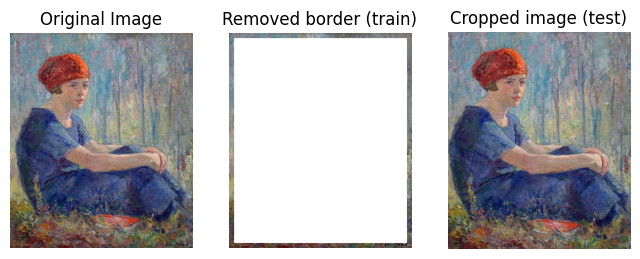

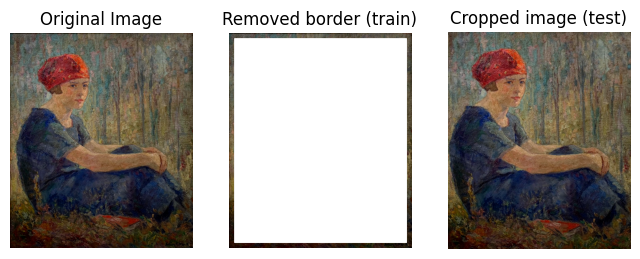

In [5]:
def remove_border(image):
    # Define the crop size
    crop_pixels = 36
    width, height = image.size

    # Create an empty transparent image
    border_only = Image.new("RGBA", (width, height), (255, 255, 255, 0))

    # Paste the original image onto the border_only image
    border_only.paste(image)

    # Now make the center area transparent
    draw = ImageDraw.Draw(border_only)
    draw.rectangle(
        [crop_pixels, crop_pixels, width - crop_pixels, height - crop_pixels],
        fill=(255, 255, 255, 0))

    # Crop the center image (cropped version)
    cropped_image = image.crop((
        crop_pixels,            # left
        crop_pixels,            # top
        width - crop_pixels,     # right
        height - crop_pixels     # bottom
    ))

    # Display the original, cropped, and removed border
    fig, axs = plt.subplots(1, 3, figsize=(8, 4))

    # Original Image
    axs[0].imshow(image)
    axs[0].set_title('Original Image')
    axs[0].axis('off')

    # Removed Border
    axs[1].imshow(border_only)
    axs[1].set_title('Removed border (train)')
    axs[1].axis('off')

    # Cropped Image
    axs[2].imshow(cropped_image)
    axs[2].set_title('Cropped image (test)')
    axs[2].axis('off')

    plt.show()

    cropped_image.save(file_path+"test/"+painting_name+"_test.png")       # Save the cropped center
    border_only.save(file_path+"train/"+painting_name+"_train.png")
    return border_only

 # Load the image
painting_name = '[56-After]'
after_train = remove_border(Image.open(file_path+painting_name+".png"))
painting_name = '[56-Before]'
before_train = remove_border(Image.open(file_path+painting_name+".png"))


# 2. Define relevant functions

In [6]:
def rgb_lab_normalized(im):
    rgb_array = np.array(im) # Convert to numpy array
    rgb_array_normalized = rgb_array / 255.0 # Normalize RGB values from 0 to 1
    lab_array_normalized = color.rgb2lab(rgb_array_normalized) # Convert RGB to LAB colorspace
    lab_array_normalized[..., 0] = (lab_array_normalized[..., 0]) / 100.0 # Scale LAB values to range [0, 1]
    lab_array_normalized[..., 1] = (lab_array_normalized[..., 1] + 128) / 255.0
    lab_array_normalized[..., 2] = (lab_array_normalized[..., 2] + 128) / 255.0
    lab_image_normalized = Image.fromarray((lab_array_normalized * 255).astype(np.uint8), mode='LAB')# Convert LAB array back to image
    return lab_image_normalized

    import tensorflow as tf
from keras.saving import register_keras_serializable

@register_keras_serializable()
def color_loss(y_true, y_pred):
    # Scale from [0,1] to [0,255]
    y_true = y_true * 255.0
    y_pred = y_pred * 255.0

    # Convert RGB to LAB
    y_true_lab = rgb_to_lab(y_true)
    y_pred_lab = rgb_to_lab(y_pred)

    # Separate L, a, b channels
    L1, a1, b1 = tf.split(y_true_lab, 3, axis=-1)
    L2, a2, b2 = tf.split(y_pred_lab, 3, axis=-1)

    # Delta calculations
    delta_L = L1 - L2
    delta_a = a1 - a2
    delta_b = b1 - b2

    delta_e = tf.sqrt(delta_L**2 + delta_a**2 + delta_b**2)

    return tf.reduce_mean(delta_e)

def rgb_to_lab(srgb):
    srgb = tf.clip_by_value(srgb, 0.0, 255.0)
    srgb = srgb / 255.0

    # Convert sRGB to XYZ
    def f(c):
        return tf.where(c > 0.04045, tf.pow((c + 0.055) / 1.055, 2.4), c / 12.92)
    rgb = f(srgb)

    rgb = tf.reshape(rgb, [-1, 3])
    matrix = tf.constant([
        [0.4124564, 0.3575761, 0.1804375],
        [0.2126729, 0.7151522, 0.0721750],
        [0.0193339, 0.1191920, 0.9503041],
    ], dtype=tf.float32)
    xyz = tf.matmul(rgb, matrix)
    xyz = tf.reshape(xyz, tf.shape(srgb))

    # Normalize for D65 white point
    xyz_ref = [0.95047, 1.0, 1.08883]
    xyz = xyz / xyz_ref

    def f_lab(t):
        delta = 6/29
        return tf.where(t > delta**3, tf.pow(t, 1/3), t / (3 * delta**2) + 4/29)

    f_xyz = f_lab(xyz)

    L = 116 * f_xyz[..., 1] - 16
    a = 500 * (f_xyz[..., 0] - f_xyz[..., 1])
    b = 200 * (f_xyz[..., 1] - f_xyz[..., 2])

    lab = tf.stack([L, a, b], axis=-1)
    return lab

# SSIM loss function
def ssim_loss(y_true, y_pred):
    return 1 - tf.reduce_mean(tf.image.ssim(y_true, y_pred, max_val=1.0))

#3. Preparing the training dataset: cropping small patches

In [8]:
def crop_patches(image):
  # Parameters
  patch_size = 8
  overlap = 4
  stride = patch_size - overlap  # move 4 pixels at a time

  # Get image size
  width, height = image.size

  # List to collect patch arrays
  patches_array = []

  # Loop over the image
  for y in range(0, height - patch_size + 1, stride):
      for x in range(0, width - patch_size + 1, stride):
          # Crop the patch
          patch = image.crop((x, y, x + patch_size, y + patch_size))

          # Check if the patch is fully opaque
          patch_data = np.array(patch)
          if patch_data.shape[2] == 4:  # RGBA
              alpha_channel = patch_data[:, :, 3]
              if not np.all(alpha_channel == 255):
                  continue  # Skip partially transparent patches

              # Keep only RGB channels (drop alpha)
              patch_rgb = patch_data[:, :, :3]
              #patch_lab = rgb_lab_normalized(patch_rgb)
              patches_array.append(patch_rgb/255)
              im1 = np.rot90(patch_rgb)
              patches_array.append(im1/255)
              im1 = np.rot90(im1)
              patches_array.append(im1/255)

  # Convert list to NumPy array
  patches_array = np.array(patches_array)
  return patches_array

input = crop_patches(before_train)
output = crop_patches(after_train)

print("Done reading the input of size = ", input.shape)
print("Done reading the output of size = ", output.shape)

# Split the data into training and testing sets
train_input, test_input, train_output, test_output = train_test_split(
    input, output, test_size=0.2, random_state=42)

print("Done reading the train input of size = ", train_input.shape)
print("Done reading the test input of size = ", test_input.shape)
print("Done reading the train output of size = ", train_input.shape)
print("Done reading the test output of size = ", test_input.shape)


input = []
output = []

Done reading the input of size =  (29340, 8, 8, 3)
Done reading the output of size =  (29340, 8, 8, 3)
Done reading the train input of size =  (23472, 8, 8, 3)
Done reading the test input of size =  (5868, 8, 8, 3)
Done reading the train output of size =  (23472, 8, 8, 3)
Done reading the test output of size =  (5868, 8, 8, 3)


## Visualize the patches

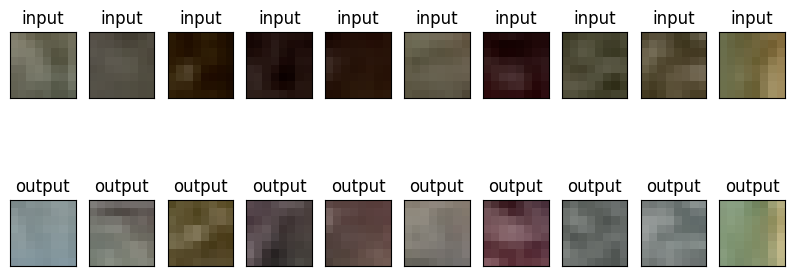

In [9]:
N = 0
n = 10
plt.figure(figsize=(10, 4))
for i in range(0,10):
    ax = plt.subplot(2, n, i + 1)
    plt.title("input")
    plt.imshow((train_input[i+N]))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    bx = plt.subplot(2, n, i + n + 1)
    plt.title("output")
    plt.imshow((train_output[i+N]))
    plt.gray()
    bx.get_xaxis().set_visible(False)
    bx.get_yaxis().set_visible(False)
plt.show()

# 4. Training

In [14]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization
from keras.optimizers import Adam
import tensorflow as tf

def unet_model(input_shape=(8, 8, 3)):
    inputs = Input(input_shape)

    # Encoder
    conv1 = Conv2D(8, 3, activation='relu', padding='same')(inputs)
    conv1 = Conv2D(8, 3, activation='relu', padding='same')(conv1)

    #conv2 = Conv2D(16, 3, activation='relu', padding='same', strides=2)(conv1)
    #conv2 = Conv2D(16, 3, activation='relu', padding='same')(conv2)

    # Decoder
    #up1 = Conv2DTranspose(8, kernel_size=3, strides=2, activation='relu', padding='same')(conv2)
    #concat1 = concatenate([up1, conv1])
    #conv3 = Conv2D(8, 3, activation='relu', padding='same')(concat1)
    #conv3 = Conv2D(8, 3, activation='relu', padding='same')(conv3)

    # Output Layer
    output = Conv2D(3, kernel_size=3, activation='sigmoid', padding='same')(conv1)

    model = Model(inputs=inputs, outputs=output)
    return model

# Usage example:
unet = unet_model()
unet.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 8, 8, 3)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 8, 8, 8)        │           224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 8, 8, 8)        │           584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 8, 8, 3)        │           219 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,027 (4.01 KB)

 Trainable params: 1,027 (4.01 KB)

 Non-trainable params: 0 (0.00 B)

In [15]:
from keras.optimizers import Adam
from tensorflow.keras import layers, losses

opt = Adam(learning_rate=0.001)
#unet.compile(optimizer=opt, loss=losses.MeanSquaredError())
unet.compile(optimizer=opt, loss=color_loss)
# Train your model as before
start = time.time()
model = unet.fit(train_input, train_output,
                epochs=100,
                shuffle=True,
                validation_data=(test_input, test_output),batch_size=32)
end = time.time()

print("The time of execution of above program is :",
      (end-start), "seconds")

unet.save(file_path + 'Model/unet_rgb_8_deltaE.keras')

Epoch 1/100
734/734 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - loss: 14.1583 - val_loss: 10.0989
Epoch 2/100
734/734 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - loss: 9.9045 - val_loss: 9.5096
Epoch 3/100
734/734 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - loss: 9.3822 - val_loss: 9.1707
Epoch 4/100
734/734 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - loss: 9.1784 - val_loss: 9.0639
Epoch 5/100
734/734 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - loss: 9.1002 - val_loss: 8.9244
Epoch 6/100
734/734 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - loss: 9.0331 - val_loss: 9.0184
Epoch 7/100
734/734 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - loss: 9.0205 - val_loss: 8.9099
Epoch 8/100
734/734 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - loss: 8.9356 - val_loss: 8.8300
Epoch 9/100
734/734 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - loss: 8.8777 - val_loss: 8.8921
Epoch 10/100
734/734 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - loss: 8.8686 - val_loss: 8.7821
Epoch 11/100
734/734 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step - loss: 8.8589 - val_loss: 8.7592
Epoch 12/100
734/734 ━━━━

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
11/11 ━━

(<Figure size 640x480 with 1 Axes>,
 <matplotlib.image.AxesImage at 0x7bbd0f618950>)

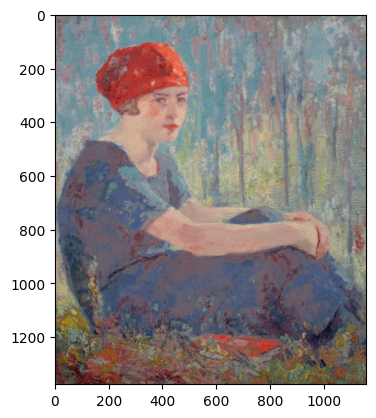

In [13]:
from tensorflow import keras
from PIL import Image, ImageOps
import numpy as np
import PIL
PIL.Image.MAX_IMAGE_PIXELS = 236958876

n_size = 8

def lab_rgb_unnormalized(lab_image):
    lab_array = np.array(lab_image/255)# Convert LAB image to numpy array
    lab_array[..., 0] = lab_array[..., 0] * 100.0# Scale LAB values back to their original ranges
    lab_array[..., 1] = (lab_array[..., 1] * 255.0) - 128
    lab_array[..., 2] = (lab_array[..., 2] * 255.0) - 128
    rgb_array_unnormalized = color.lab2rgb(lab_array)# Convert LAB to RGB colorspace
    rgb_array_unnormalized = (rgb_array_unnormalized * 255).astype(np.uint8)# Scale RGB values back to the range [0, 255]
    rgb_image_unnormalized = Image.fromarray(rgb_array_unnormalized, mode='RGB')# Convert RGB array back to image
    return rgb_image_unnormalized

def AB_rgb_unnormalized(lab_image, test_L):
    lab_array = np.array(lab_image/255)# Convert LAB image to numpy array
    lab_array[..., 0] = test_L #replacing L from the original input
    lab_array[..., 1] = (lab_array[..., 1] * 255.0) - 128
    lab_array[..., 2] = (lab_array[..., 2] * 255.0) - 128
    rgb_array_unnormalized = color.lab2rgb(lab_array)# Convert LAB to RGB colorspace
    rgb_array_unnormalized = (rgb_array_unnormalized * 255).astype(np.uint8)# Scale RGB values back to the range [0, 255]
    rgb_image_unnormalized = Image.fromarray(rgb_array_unnormalized, mode='RGB')# Convert RGB array back to image
    return rgb_image_unnormalized

def crop_(im):
    width, height = im.size
    data = []
    for j in np.arange(0,int(height/n_size),0.5):
        for i in range(0,int(width/n_size)):
            im1 = im.crop((0 + (n_size*i), 0 + (n_size*j), n_size + (n_size*i), n_size + (n_size*j)))
            im1 = np.array(im1)
            im1 = im1.astype(np.float32)
            data.append(im1)
    return data


#----------------READING THE TEST IMAGE--------------------#
test = Image.open(file_path+ "test/" + "[56-Before]_test.png").convert('RGB')
test = ImageOps.expand(test, border=2, fill='black')
w_dirty, h_dirty = test.size
#----------------------------------------------------------#

from keras.models import load_model

#autoencoder = load_model(file_path + 'Model/unet_rgb.keras', custom_objects={'ssim_loss': ssim_loss})
autoencoder = load_model(file_path + 'Model/unet_rgb_8_deltaE.keras', custom_objects={'color_error_loss': color_loss})


xx = int(w_dirty/n_size)
final=[]
for portion in np.arange(0,xx, 0.5):
    im1 = test.crop((n_size*portion, 0, (n_size*portion) + n_size, h_dirty))
    w1, h1 = im1.size
    w = int(w1/n_size)
    h = int(h1/n_size)
    neverbeforeseen = np.array(crop_(im1))
    neverbeforeseen = neverbeforeseen[:,:,:,0:3]
    neverbeforeseen = np.array(neverbeforeseen).astype(np.float32)/255.0
    decoded_imgs = autoencoder.predict(neverbeforeseen)
    decoded_imgs = decoded_imgs[:, 2:6, 2:6, :]
    col = np.vstack((decoded_imgs[0],decoded_imgs[1]))
    for i in range(2,len(decoded_imgs)):
        col = np.vstack((col,decoded_imgs[i]))
    y = col
    y = (y * 255).astype('uint8')
    if portion == 0:
        final = y
    if portion > 0:
        final = np.hstack((final,y))

reconstructed = Image.fromarray(np.squeeze(final))
reconstructed.save(file_path + "test/"+painting_name+"_cnn.png")
plt.figure(), plt.imshow(reconstructed)
